# Aim: To identify factors that lead to an accident alongside its severity and identification of accident blackspots.

# Objectives:
__1) Obtain labelled dataset __

__2) Preprocess and integrate dataset __

__3) Analyse dataset and perform dimensionality reduction techniques to identify factors which are highly correlated with accidents __

__4) Train a model with filtered dataset to forecast accident severity __

__5) GUI?? __

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pprint
%matplotlib inline

from scipy.stats import gaussian_kde
from mpl_toolkits.basemap import Basemap
from sklearn import preprocessing
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *

# Import dataset

In [9]:
acc = pd.read_csv('acc2005_2016.csv', low_memory=False)
cas = pd.read_csv('cas2005_2016.csv')
veh = pd.read_csv('veh2005_2016.csv')

# Initialise

## Drop columns/Row
Remove any feature if they meet criteria:
* Duplicate features, where the multiple features are contextually identical but represented differently
* Contextually irrelevant data, i.e. any indexing/referencing features
* Features with > 20% missing data, such data are not useful for the predictors and severely limits learning.

Remove data points which are NaN.

In [10]:
acc.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Police_Force', 'X2nd_Road_Class', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Junction_Control'], axis=1, inplace=True)
cas.drop(['Age_of_Casualty', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_IMD_Decile', 'Vehicle_Reference', 'Casualty_Reference'], axis=1, inplace=True)
veh.drop(['Vehicle_Reference', 'Journey_Purpose_of_Driver', 'Age_of_Driver', 'Engine_Capacity_.CC.', 'Propulsion_Code', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile', 'Age_of_Vehicle'], axis=1, inplace=True)

In [11]:
acc.rename(columns={'Local_Authority_.District.': 'Local_Authority_District',
                   'Local_Authority_.Highway.': 'Local_Authority_Highway',
                   'Speed_limit': 'Speed_Limit',
                   'Pedestrian_Crossing.Human_Control': 'Pedestrian_Crossing_Human_Control',
                   'Pedestrian_Crossing.Physical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'}, inplace=True)
veh.rename(columns={'Was_Vehicle_Left_Hand_Drive.': 'Was_Vehicle_Left_Hand_Drive', 
                   'Vehicle_Location.Restricted_Lane': 'Vehicle_Location_Restricted_Lane'
                   }, inplace=True)
acc = acc.dropna(subset=['Longitude', 'Latitude', 'Time', 'Speed_Limit'])

1) Convert any date/time series to pandas datetime type

2) Split date and time to denominators of year, month, day, hour and minute

In [12]:
acc.loc[:, ('Date')] = pd.to_datetime(acc['Date'])

acc.loc[:, ('Time')] = pd.to_datetime(acc['Time'], format='%H:%M')

acc = acc.assign(Year=acc.Date.dt.year, Month=acc.Date.dt.month, Day=acc.Date.dt.day, Hour=acc.Time.dt.hour, Minute=acc.Time.dt.minute)

## Combine all feature

In [13]:
# tap = pd.merge(acc, cas, how='inner', on='Accident_Index')
# tap = pd.DataFrame({'as': tap.Accident_Severity, 'cs': tap.Casualty_Severity})

# cnt_distinct = 0
# for t in tap.itertuples():
#     if t[1] != t[2]:
#         cnt_distinct += 1

# print('Distinct ac cs: {}'.format(cnt_distinct))
# print('Percent diff: {}'.format((cnt_distinct/len(tap)) * 100))

# Function list

Visualise histograms in bulk

In [14]:
def bulkVisualiseHist(fig, data, drop_col, ncol, nrow=-1):
    splt_ind = 1
    data_col = data.columns.drop(drop_col)
    if nrow <= 0:
        nrow = math.ceil(len(data_col) / ncol)
    for i in data_col:
        sfig = fig.add_subplot(nrow, ncol, splt_ind)
        num_bins = len(pd.unique(data[i]))
        if num_bins > 20:
            sfig.hist(data[i])
        else:
            sfig.hist(data[i], bins=num_bins)
        sfig.set_title(i)
        splt_ind += 1
    return splt_ind

Visualise gaussian KDE

__WARNING: iNCREDIBLY SLOW__

In [15]:
def visualiseGaussianKDE(subplot, x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    subplot.scatter(x, y, c=z, s=50, edgecolor='')

Get the sum of values for each class in a feature set

In [16]:
def get_sum_feature_uniq(feature):
    sum_list = pd.unique(feature)
    sum_dict = dict()
    for i in sum_list:
        sum_dict[str(i)] = sum(feature == i)
    return sum_dict

Utility for matplotlib.pyplot.figure

Assign text to global plot X or Y axis

In [17]:
def set_pltxytxt(fig, axis, **kwargs):
    if axis.lower() == 'xy':
        fig.text(0.5, 0.04, kwargs['x'], ha='center')
        fig.text(0.04, 0.5, kwargs['y'], va='center', rotation='vertical')
    elif axis.lower() == 'x':
        fig.text(0.5, 0.04, kwargs['x'], ha='center')
    elif axis.lower() == 'y':
        fig.text(0.04, 0.5, kwargs['y'], va='center', rotation='vertical')
    else:
        print('Axis only accepts "x", "y" and "xy" as inputs')

## Initialise UK bank holiday dates
__Xmas + Boxing day pair seems to have some issues__

In [18]:
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=nearest_workday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=nearest_workday),
        Holiday('Boxing Day', month=12, day=26, observance=after_nearest_workday)
    ]

def after_nearest_workday(dt):
    """
    returns next workday after nearest workday
    needed for Boxing day or multiple holidays in a series
    """
    return next_workday(nearest_workday(dt))

# General analysis

In [19]:
def checkNegOne(data, **kwargs):
    data_cols = data.columns
    if 'dropcol' in kwargs:
        data_cols = data_cols.drop(kwargs['dropcol'])
    data_len = len(data)
    data_range = range(0, len(data) - 1)
    
    cnt_negs = dict()
    for col in data_cols:
        if np.issubdtype(data[col].loc[1], np.number):
            len_negs = len(list(filter(lambda x: x == -1, data[col])))
            if len_negs > 0:
                cnt_negs[col] = [len_negs, ((len_negs/data_len) * 100)]
    
    return cnt_negs

acc_negs = checkNegOne(acc, dropcol=['Accident_Index', 'Date', 'Time', 'Local_Authority_Highway', 'Longitude', 'Latitude'])
cas_negs = checkNegOne(cas, dropcol=['Accident_Index'])
veh_negs = checkNegOne(veh, dropcol=['Accident_Index'])

pprint.pprint(acc_negs, width=1)
pprint.pprint(cas_negs, width=1)
pprint.pprint(veh_negs, width=1)

{'Carriageway_Hazards': [669,
                         0.03489938907810838],
 'Junction_Detail': [123,
                     0.006416479606288984],
 'Light_Conditions': [9,
                      0.0004694985077772428],
 'Pedestrian_Crossing_Human_Control': [339,
                                       0.01768444379294281],
 'Pedestrian_Crossing_Physical_Facilities': [787,
                                             0.04105503618007667],
 'Road_Surface_Conditions': [3199,
                             0.16688063626437774],
 'Special_Conditions_at_Site': [625,
                                0.032604063040086305],
 'Weather_Conditions': [170,
                        0.008868305146903475],
 'X1st_Road_Number': [2,
                      0.00010433300172827618],
 'X2nd_Road_Number': [17420,
                      0.9087404450532854]}
{'Age_Band_of_Casualty': [51760,
                          2.0028688697450328],
 'Bus_or_Coach_Passenger': [101,
                            0.003908225576589032]

In [20]:
def gen_util_plotter(subplot, **kwargs):
    subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['y'].reshape(-1, 1)), marker='o', label='Accidents')
    if 'cv' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['c'].reshape(-1, 1)), marker='1', label='Casualties')
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['v'].reshape(-1, 1)), marker='8', label='Vehicles')
        subplot.legend()
    if 'title' in kwargs:
        subplot.set_title(kwargs['title'])
    if 'set_xticks' in kwargs:
        if kwargs['set_xticks']:
            subplot.set_xticks(x)
    
def gen_xyunzip_list(data, feature):
    return map(np.array, 
                   zip(*[(i, len(data.loc[data[feature] == i])) 
                         for i in range(min(data[feature]), max(data[feature]) + 1)]))

def gen_cv_list(feature, **kwargs):
    if kwargs is None:
        return -1
    ret = dict()
    acc_idx = [acc.loc[acc[feature] == i].set_index('Accident_Index').index 
               for i in range(min(acc[feature]), max(acc[feature]) + 1)]
    if 'c' in kwargs:
        ret['c'] = np.array([len(cas[cas.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    if 'v' in kwargs:
        ret['v'] = np.array([len(veh[veh.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    
    return ret

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


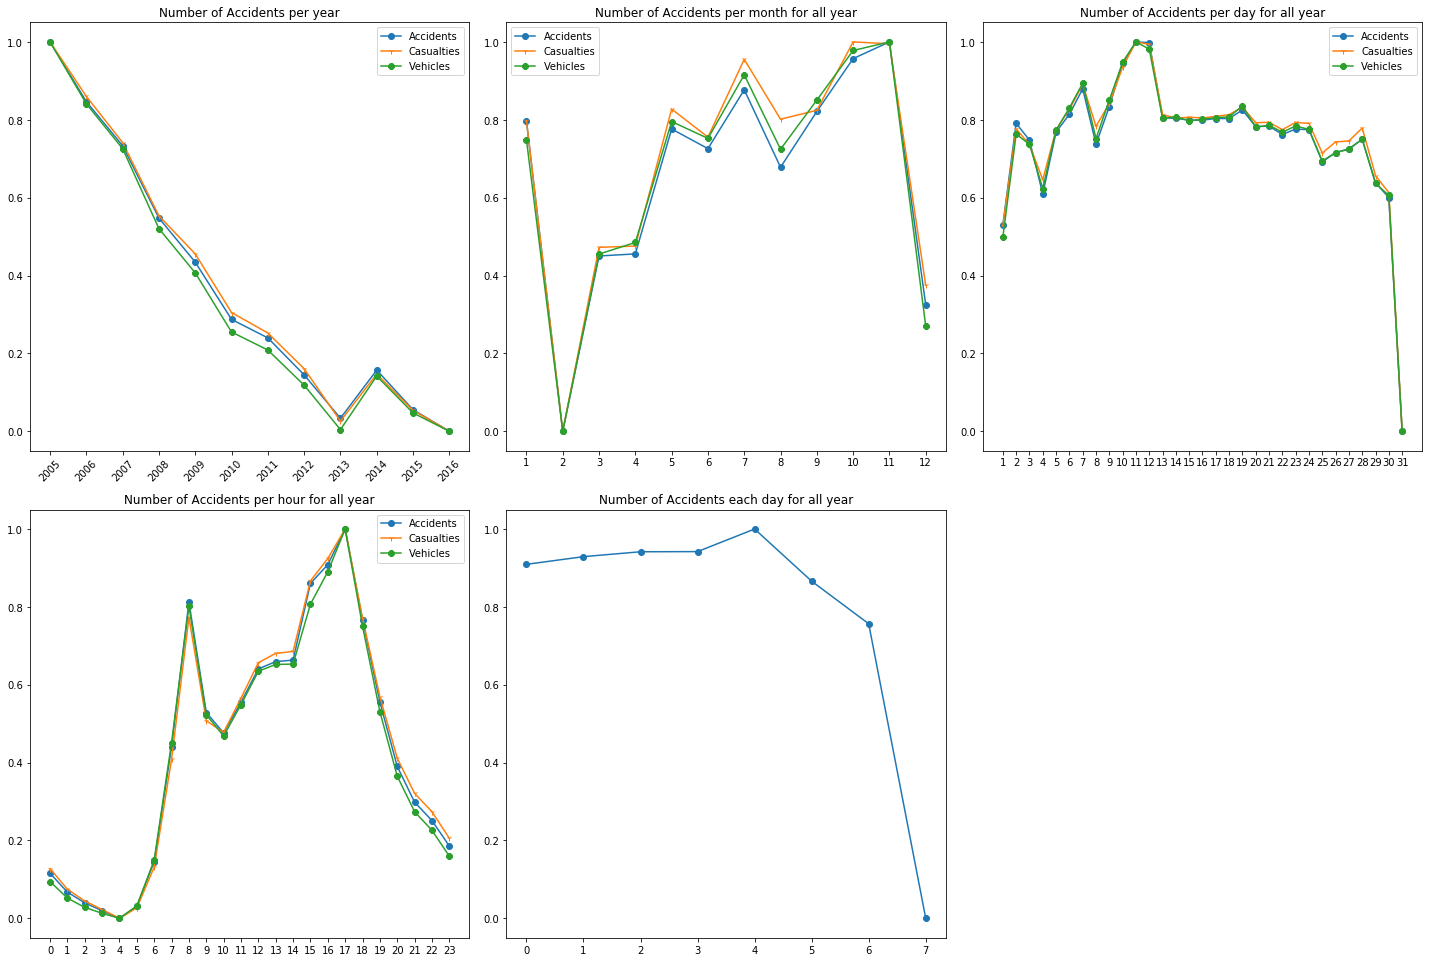

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
fig_general = plt.figure(figsize=[20,20])
nrow, ncol, splt_ind = 3, 3, 1

# Display plot for accidents per year
x, y = gen_xyunzip_list(acc, 'Year')
cv = gen_cv_list('Year', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per year', set_xticks=True)
ax.set_xticklabels(x, rotation=45)
splt_ind += 1

# Display plot for accident per month for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Month')
cv = gen_cv_list('Month', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per month for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per day for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Day')
cv = gen_cv_list('Day', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per day for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per hour for all years
x, y = gen_xyunzip_list(acc, 'Hour')
cv = gen_cv_list('Hour', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per hour for all year', set_xticks=True)
splt_ind += 1

ukhol = UKBankHolidays()
# Display plot for accident for each day for all years
# TODO: Holidays + Weekend as 7
# Legend:
#    0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday
ukbh = UKBankHolidays()
hols = ukbh.holidays(min(acc.Date), max(acc.Date))

acc_date_ind = acc.set_index('Date').index
acc_hols = acc_date_ind.isin(hols)

x = np.array([i for i in range(0, 8)])
y = np.array([len(list(filter(lambda x : x == True, acc.Date.dt.dayofweek == i))) for i in range(0, 7)])
y = np.append(y, [len(list(filter(lambda x: x == True, acc_hols)))])

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
ax.plot(x, min_max_scaler.fit_transform(y.reshape(-1, 1)), marker='o')
ax.set_title('Number of Accidents each day for all year')
ax.set_xticks(x)
splt_ind += 1

plt.tight_layout()
plt.show()

# ACC05

In [22]:
acc05 = acc.loc[acc.Year == 2005]
acc05.describe()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_District,X1st_Road_Class,X1st_Road_Number,Road_Type,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Year,Month,Day,Hour,Minute
count,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,...,198637.000000,198637.000000,198637.000000,198637.000000,198637.000000,198637.0,198637.000000,198637.000000,198637.000000,198637.000000
mean,-1.490342,52.602474,2.844742,1.842849,1.363739,4.128214,355.816595,4.113176,993.397207,5.166006,...,1.588677,1.356484,0.112869,0.074961,1.363970,2005.0,6.591295,15.794620,13.732074,26.756264
std,1.403924,1.450570,0.400604,0.725667,0.817209,1.926532,258.566919,1.450456,1828.959720,1.646455,...,1.675645,0.599299,0.742630,0.615919,0.481361,0.0,3.443950,8.614668,5.212282,17.450841
min,-7.369061,49.914701,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,...,1.000000,-1.000000,-1.000000,-1.000000,1.000000,2005.0,1.000000,1.000000,0.000000,0.000000
25%,-2.428284,51.494834,3.000000,1.000000,1.000000,2.000000,121.000000,3.000000,0.000000,6.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,2005.0,4.000000,9.000000,10.000000,11.000000
50%,-1.471677,52.386302,3.000000,2.000000,1.000000,4.000000,328.000000,4.000000,104.000000,6.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,2005.0,7.000000,16.000000,14.000000,29.000000
75%,-0.264519,53.478848,3.000000,2.000000,1.000000,6.000000,533.000000,6.000000,684.000000,6.000000,...,1.000000,2.000000,0.000000,0.000000,2.000000,2005.0,10.000000,23.000000,17.000000,41.000000
max,1.758337,60.586586,3.000000,20.000000,35.000000,7.000000,941.000000,6.000000,9999.000000,9.000000,...,9.000000,5.000000,7.000000,7.000000,3.000000,2005.0,12.000000,31.000000,23.000000,59.000000


D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


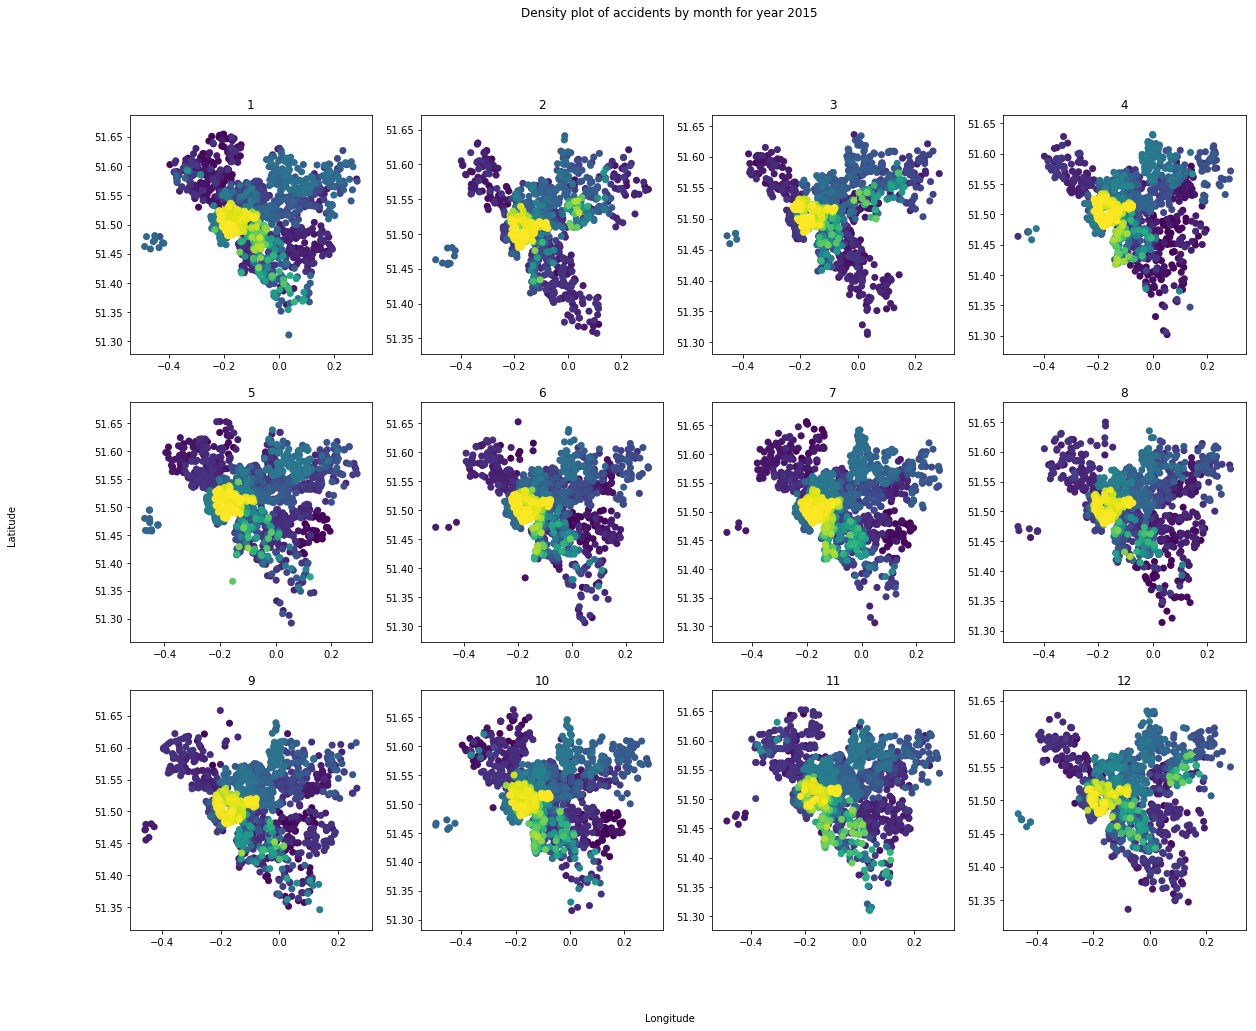

In [23]:
fig_gaussian_coord = plt.figure(figsize=[20,15])

for i in range(min(acc05.Month), max(acc05.Month) + 1):
    sfig_gaussian_coord = fig_gaussian_coord.add_subplot(3, 4, i)
    prealloc_acc05_data = acc05.loc[acc05.Month == i]
    visualiseGaussianKDE(sfig_gaussian_coord, prealloc_acc05_data.Longitude, prealloc_acc05_data.Latitude)
    sfig_gaussian_coord.set_title(i)

fig_gaussian_coord.suptitle('Density plot of accidents by month for year 2015')
set_pltxytxt(fig_gaussian_coord, 'xy', x='Longitude', y='Latitude')
plt.show()

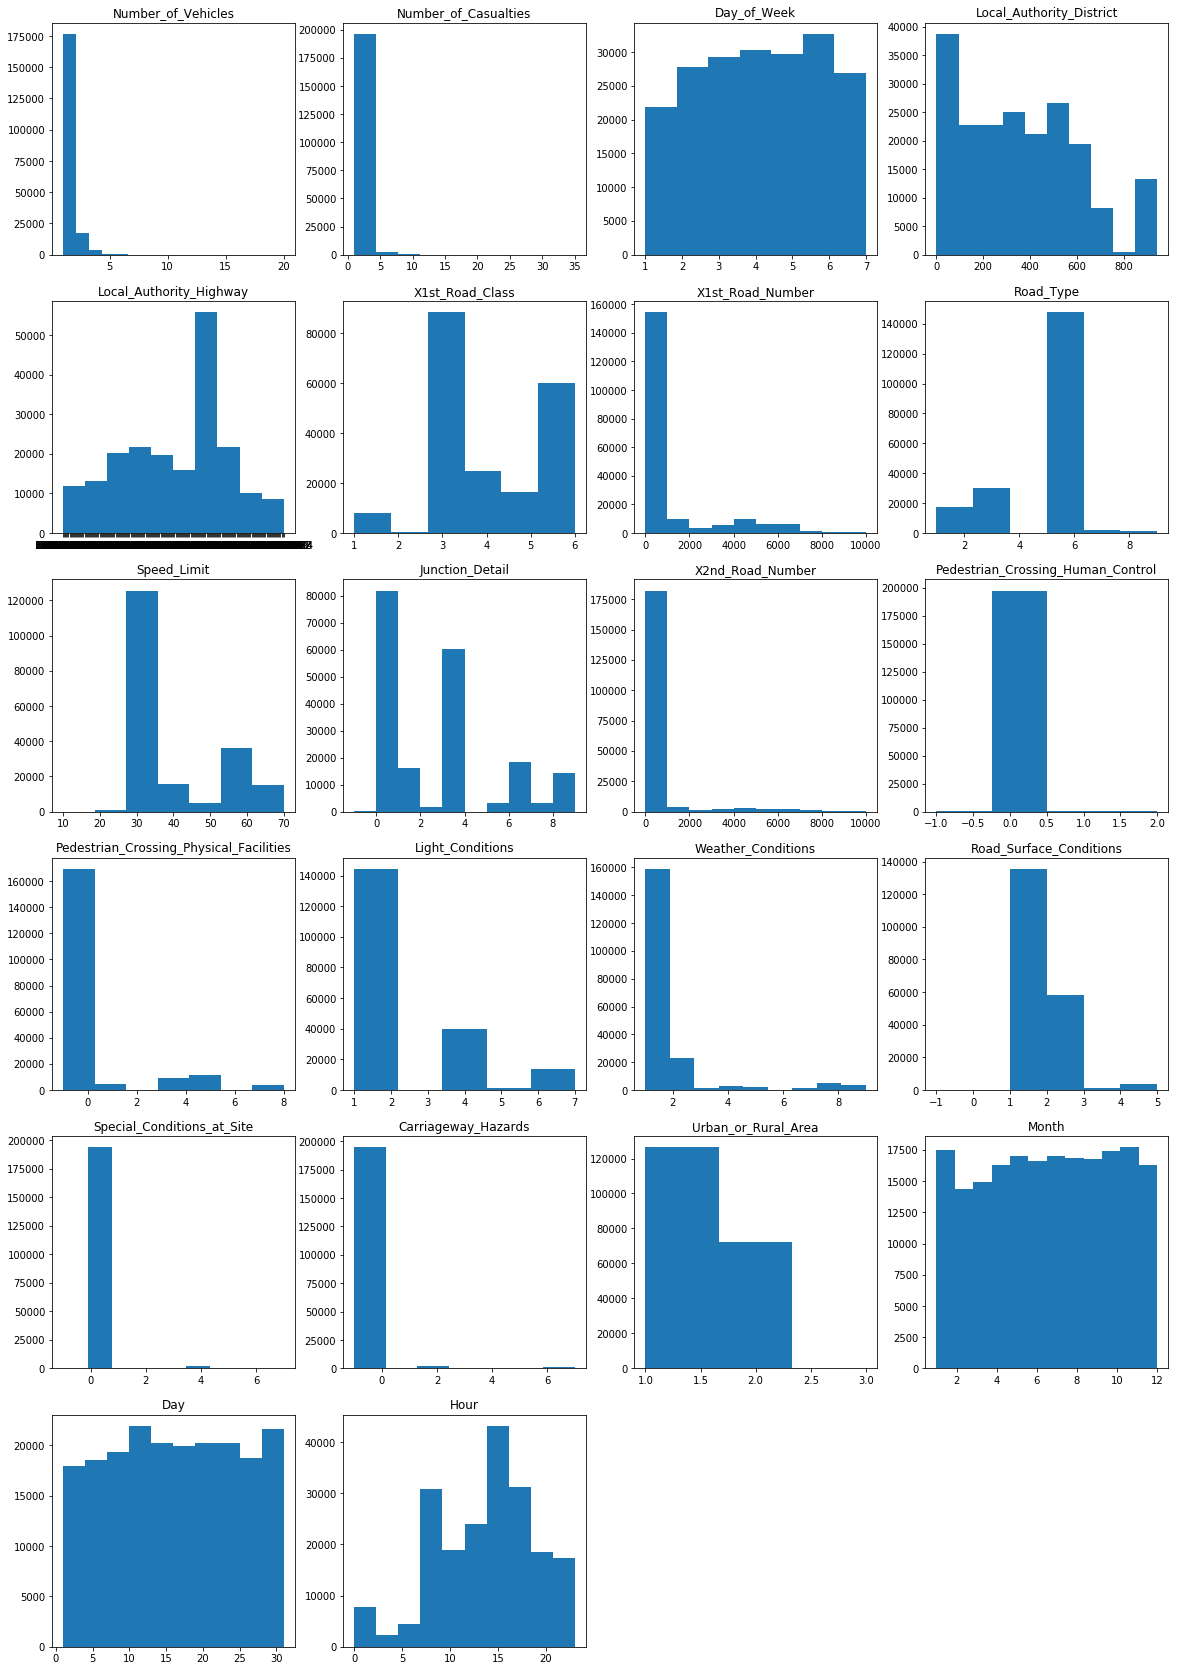

In [24]:
fig_acc05 = plt.figure(figsize=[20,35])
drop_col = ['Accident_Index', 'Longitude', 'Latitude', 'Date', 'Time', 'Accident_Severity', 'Year', 'Minute']
sfig_ind = bulkVisualiseHist(fig_acc05, acc05, drop_col, ncol=4, nrow=7)

plt.show()

# CAS05

In [25]:
cas05 = cas.merge(acc05, on='Accident_Index', how='inner')
cas05.drop(acc05.columns.drop('Accident_Index'), axis=1, inplace=True)
cas05.describe()

,Casualty_Class,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type,Casualty_Home_Area_Type
count,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000,270889.000000
mean,1.502132,1.416318,5.850529,2.869544,0.667247,0.462403,0.295992,0.090683,7.615529,0.847528
std,0.703986,0.495883,2.451022,0.370231,1.963327,1.629045,0.601273,0.566081,6.431527,1.125165
min,1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000
25%,1.000000,1.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000
50%,1.000000,1.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000
75%,2.000000,2.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000
max,3.000000,2.000000,11.000000,3.000000,10.000000,9.000000,2.000000,4.000000,90.000000,3.000000


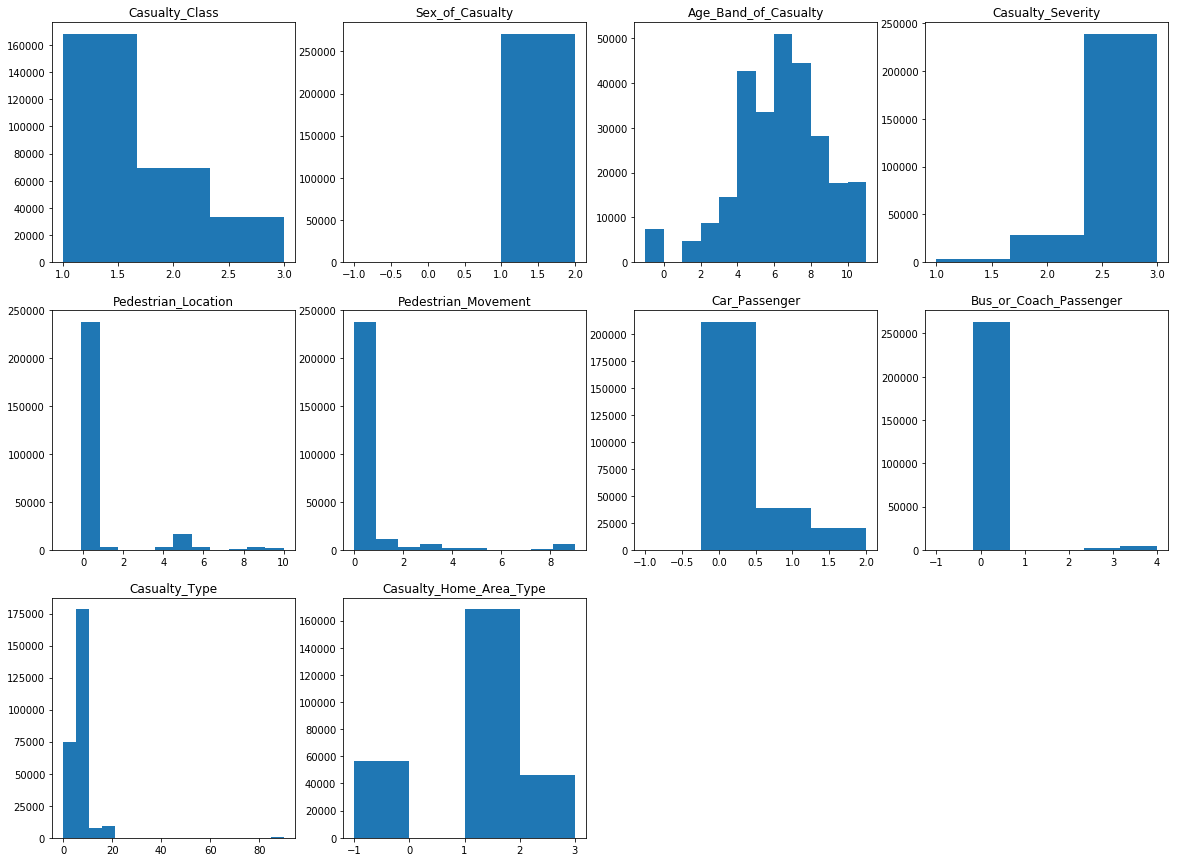

In [26]:
fig_cas05 = plt.figure(figsize=[20,15])
drop_col = ['Accident_Index']
bulkVisualiseHist(fig=fig_cas05, data=cas05, drop_col=drop_col, ncol=4)
plt.show()

# VEH05

In [27]:
veh05 = veh.merge(acc05, on='Accident_Index', how='inner')
veh05.drop(acc05.columns.drop('Accident_Index'), axis=1, inplace=True)
veh05.describe()

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location_Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,X1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive,Sex_of_Driver,Age_Band_of_Driver,Driver_Home_Area_Type
count,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000,366058.000000
mean,9.652301,0.035022,12.807938,0.129925,2.380167,0.238197,0.309183,0.395863,0.589617,1.726385,0.936160,1.387930,5.703309,0.777082
std,7.413577,0.322724,6.140949,0.978688,3.078552,0.736321,1.620056,1.430696,2.127628,1.145413,0.372017,0.592962,2.920794,1.170972
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000,1.000000
50%,9.000000,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,6.000000,1.000000
75%,9.000000,0.000000,18.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,7.000000,1.000000
max,90.000000,5.000000,18.000000,9.000000,8.000000,5.000000,12.000000,8.000000,10.000000,4.000000,2.000000,3.000000,11.000000,3.000000


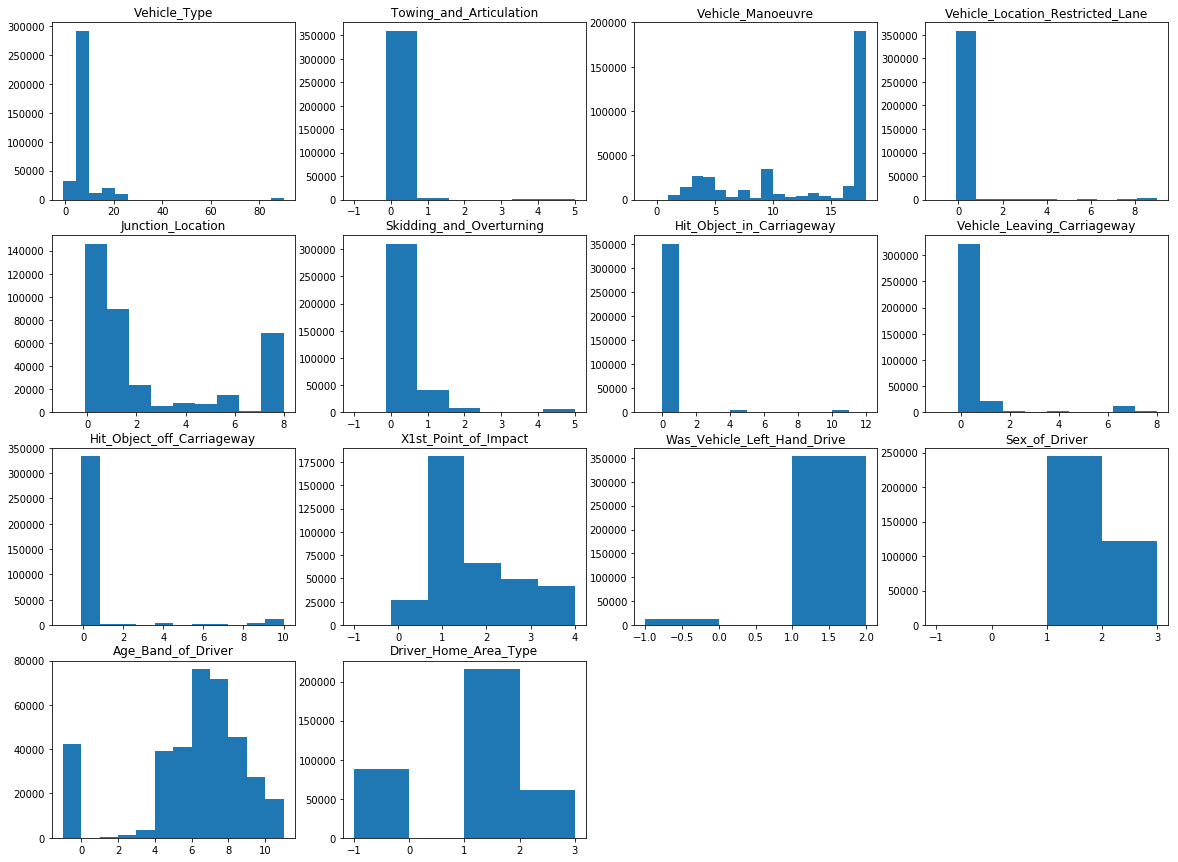

In [28]:
fig_veh05 = plt.figure(figsize=[20,15])
drop_col = ['Accident_Index']
bulkVisualiseHist(fig_veh05, veh05, drop_col, 4)
plt.show()

# Missing value impute vs non-impute validation

In [31]:
acc_na = acc.copy()
for k, v in acc_negs.items():
    acc_na[k] = acc[k].replace(-1, np.nan)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

# Preprocessing
le_jc = preprocessing.LabelEncoder()
le_jc.fit(acc_na.Local_Authority_Highway)
acc_na.loc[:, ('Local_Authority_Highway')] = le_jc.transform(acc_na.Local_Authority_Highway)

# Remove:
# Accident_Index - Index value useless for predictor
# Accident_Severity - TARGET
# Date - Decomposed into Year, Month, Day
# Time - Decomposed into Hour, Minute
acc_na = acc_na.drop(['Accident_Index', 'Date', 'Time'], axis=1)

# Estimate data by dropping all missing data
acc_drop = acc_na.dropna()
X_drop, Y_drop = acc_drop.drop(['Accident_Severity'], axis=1), acc_drop.Accident_Severity
rf_est = RandomForestClassifier(random_state=0, n_estimators=100)
score = cross_val_score(rf_est, X_drop, Y_drop, n_jobs=3).mean()
print('Score for non-impute data: {}'.format(score))
del acc_drop
del X_drop
del Y_drop

# Estimate data with imputed values
X_full, Y_full = acc_na.drop(['Accident_Severity'], axis=1), acc_na.Accident_Severity
for strat in ['mean', 'median', 'most_frequent']:
    rf_est = Pipeline([("imputer", Imputer(missing_values=np.nan,
                                          strategy=strat,
                                          axis=0)),
                      ("forest", RandomForestClassifier(random_state=0,
                                                       n_estimators=100))])
    score = cross_val_score(rf_est, X_full, Y_full, n_jobs=3).mean()
    print('Score for impute data [{}]: {}'.format(strat, score))

Score for non-impute data: 0.5181803809864974
Score for impute data [mean]: 0.5237012326793965
Score for impute data [median]: 0.5126732453664191
Score for impute data [most_frequent]: 0.5083074426527646
